In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import torch
import src.lvm as lvm
import src.data as data
import src.visualization as visualization
torch.set_default_dtype(torch.double)

# Data and Model loading

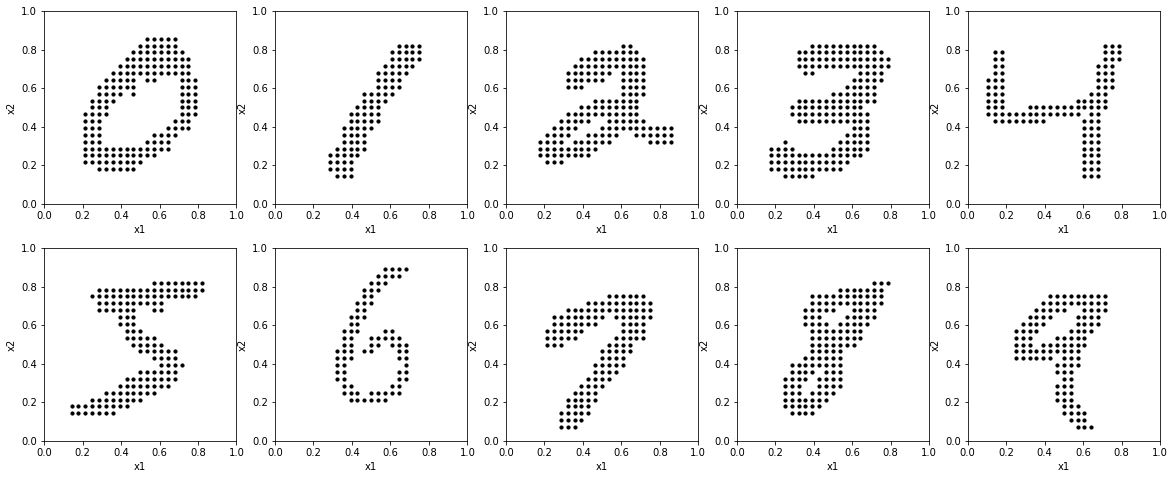

In [2]:
D = data.load_data()
visualization.show_data(D)

In [3]:
model = lvm.SetModel(device=lvm.DEVICE, z_dim=2, w_dim=2)
model.load_state_dict(torch.load("model/model_final_10_shapes.pt"))

f parameter count: 354 . g parameter count: 79029


<All keys matched successfully>

In [4]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
#optimizer.load_state_dict(torch.load("model/optimizer_final_10_shapes.pt"))

# Optimization

In [5]:
lvm.optimize(model=model, optimizer=optimizer, data=D, epochs=10, report_at=1, sample_size_z=32, sample_size_w=32)

0 expectation: tensor(5219.9449) | model variance: tensor(-6.9078)
1 expectation: tensor(5264.1673) | model variance: tensor(-6.9078)
2 expectation: tensor(4893.5858) | model variance: tensor(-6.9078)
3 expectation: tensor(5271.5997) | model variance: tensor(-6.9078)
4 expectation: tensor(5760.3285) | model variance: tensor(-6.9078)
5 expectation: tensor(4507.0247) | model variance: tensor(-6.9078)
6 expectation: tensor(4860.2285) | model variance: tensor(-6.9078)
7 expectation: tensor(5569.6730) | model variance: tensor(-6.9078)
8 expectation: tensor(4957.8489) | model variance: tensor(-6.9078)
9 expectation: tensor(5283.9289) | model variance: tensor(-6.9078)


# Evaluation of optimized Model

## Generate Random Samples

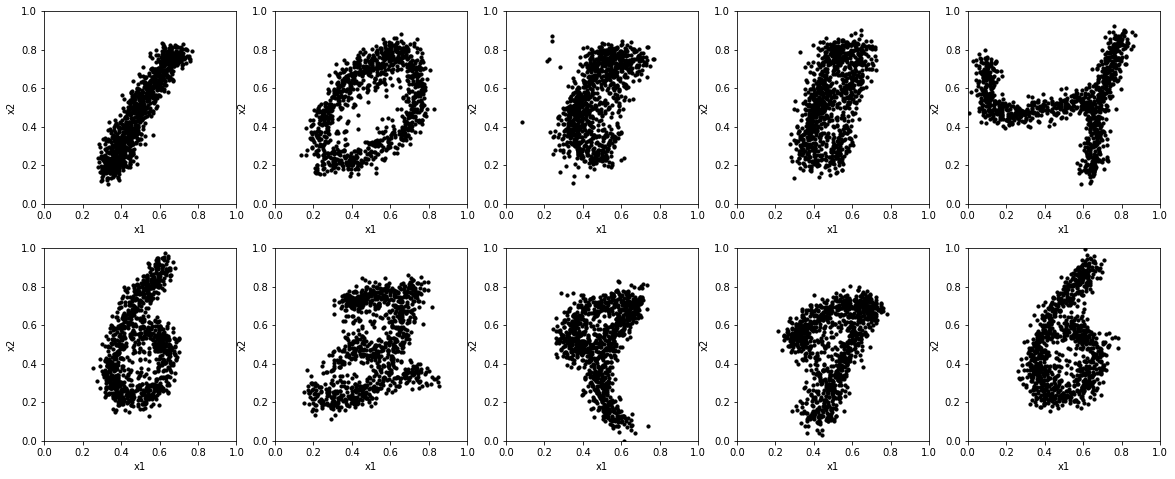

In [30]:
D_gen = model.sample(w_size=10, z_size=1024).detach()
visualization.show_data(D_gen)

## Posterior Distributions p(w|X)

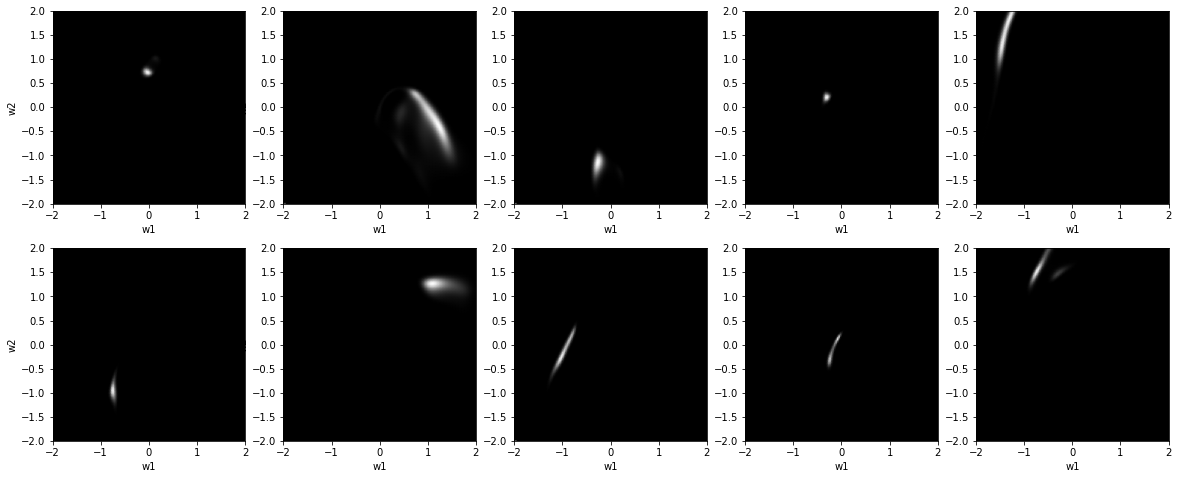

In [7]:
w_axis_scale, w_grid, w_posteriors = lvm.calculate_set_model_posterior_distributions(model=model, D=D, resolution=128)
visualization.show_densities(axis_scale=w_axis_scale, probabilities=w_posteriors, variable_name="w")

## Conditional Distributions p(x|w)

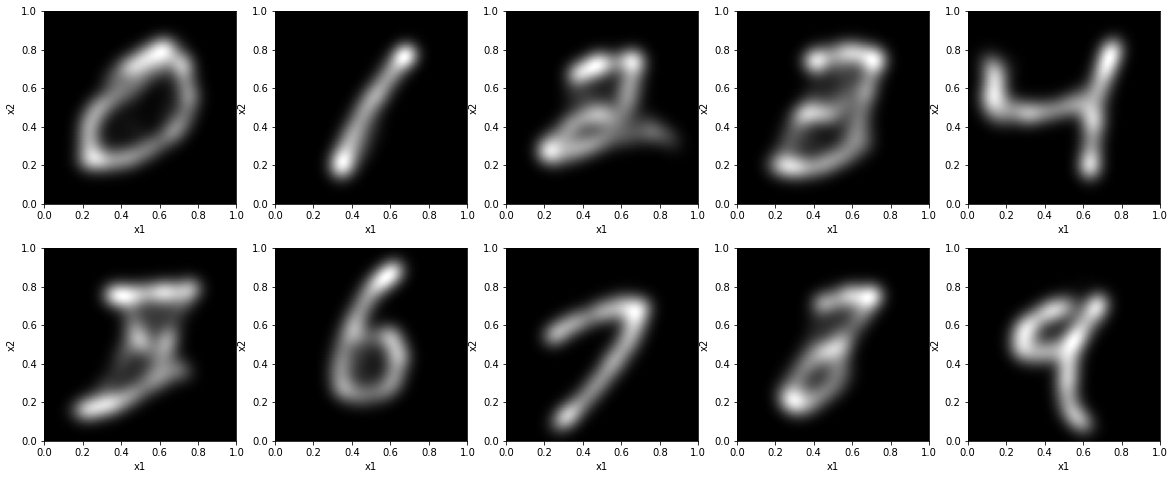

In [8]:
w_maxima = [w_grid.reshape((-1, 2))[posterior.flatten().argmax()] for posterior in w_posteriors]
x_axis_scale, x_grid, conditional_distributions = lvm.calculate_conditional_distributions(model=model, w=w_maxima, resolution=128)
visualization.show_densities(axis_scale=x_axis_scale, probabilities=conditional_distributions, variable_name="x")

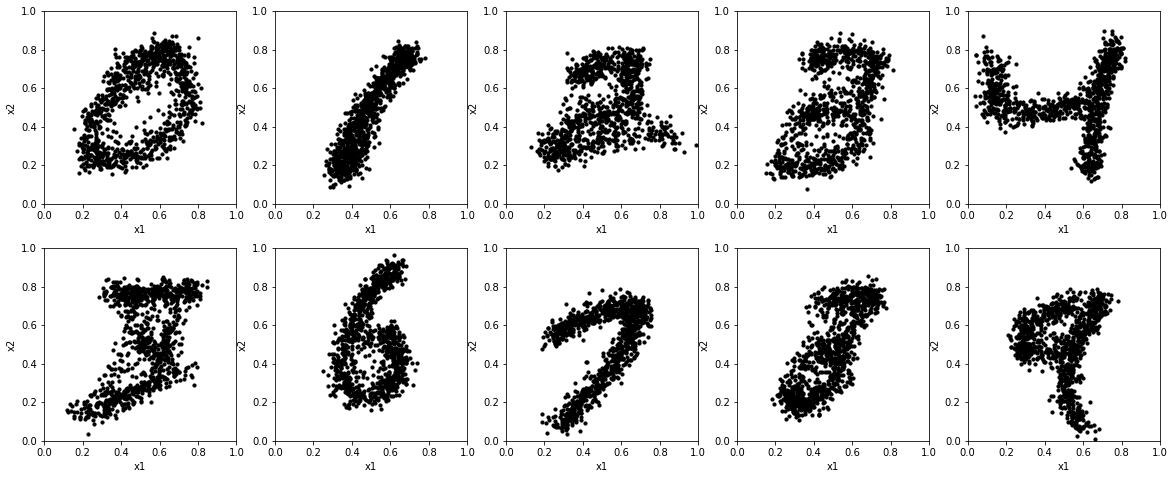

In [9]:
# Sampling from those distributions
D_gen_maxima = []
for wi in w_maxima:
    D_gen_maxima.append(model.shape_model.sample(1024, wi).detach())
visualization.show_data(D_gen_maxima)

## Posterior Distributions p(z|x, w)

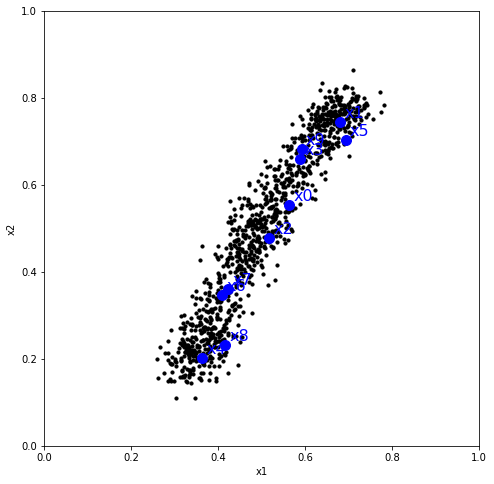

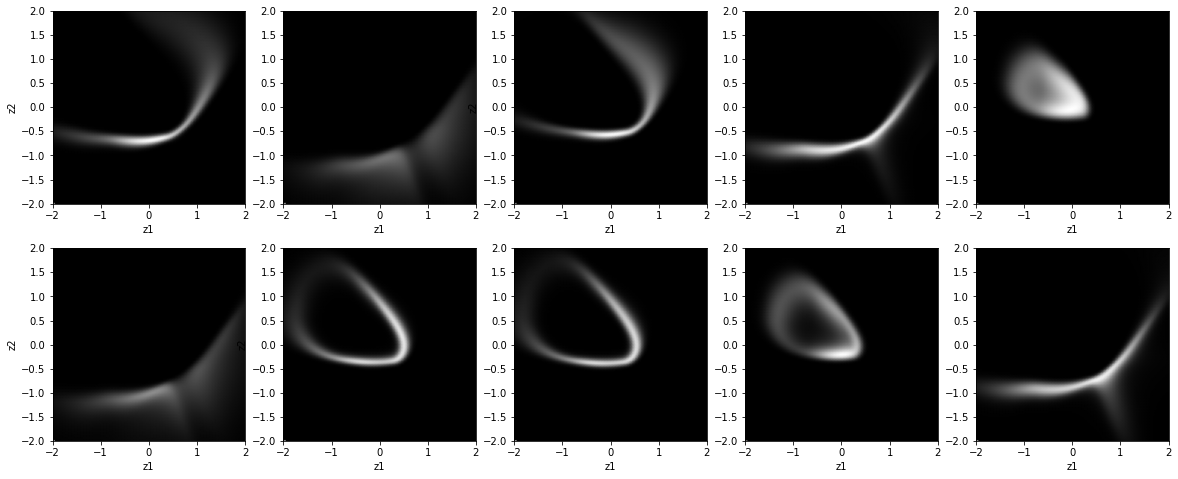

In [12]:
# Draw a random shape and sample from its distribution to obtain X, select a small subset to perform inference on.
w = torch.normal(mean=torch.zeros(2), std=torch.ones(2))
X = model.shape_model.sample(size=1024, w=w)
X_subset = X[torch.randperm(len(X))[:10]]
visualization.scatter_2d_data_and_subset(data=X, subset=X_subset)

# Calculate the posterior distributions for elements of the subset of X.
z_axis_scale, z_grid, z_posteriors = lvm.calculate_shape_model_posterior_distributions(model=model.shape_model, X=X_subset, w=w, resolution=128)
visualization.show_densities(axis_scale=z_axis_scale, probabilities=z_posteriors, variable_name="z")

## Latent Space w Exploration

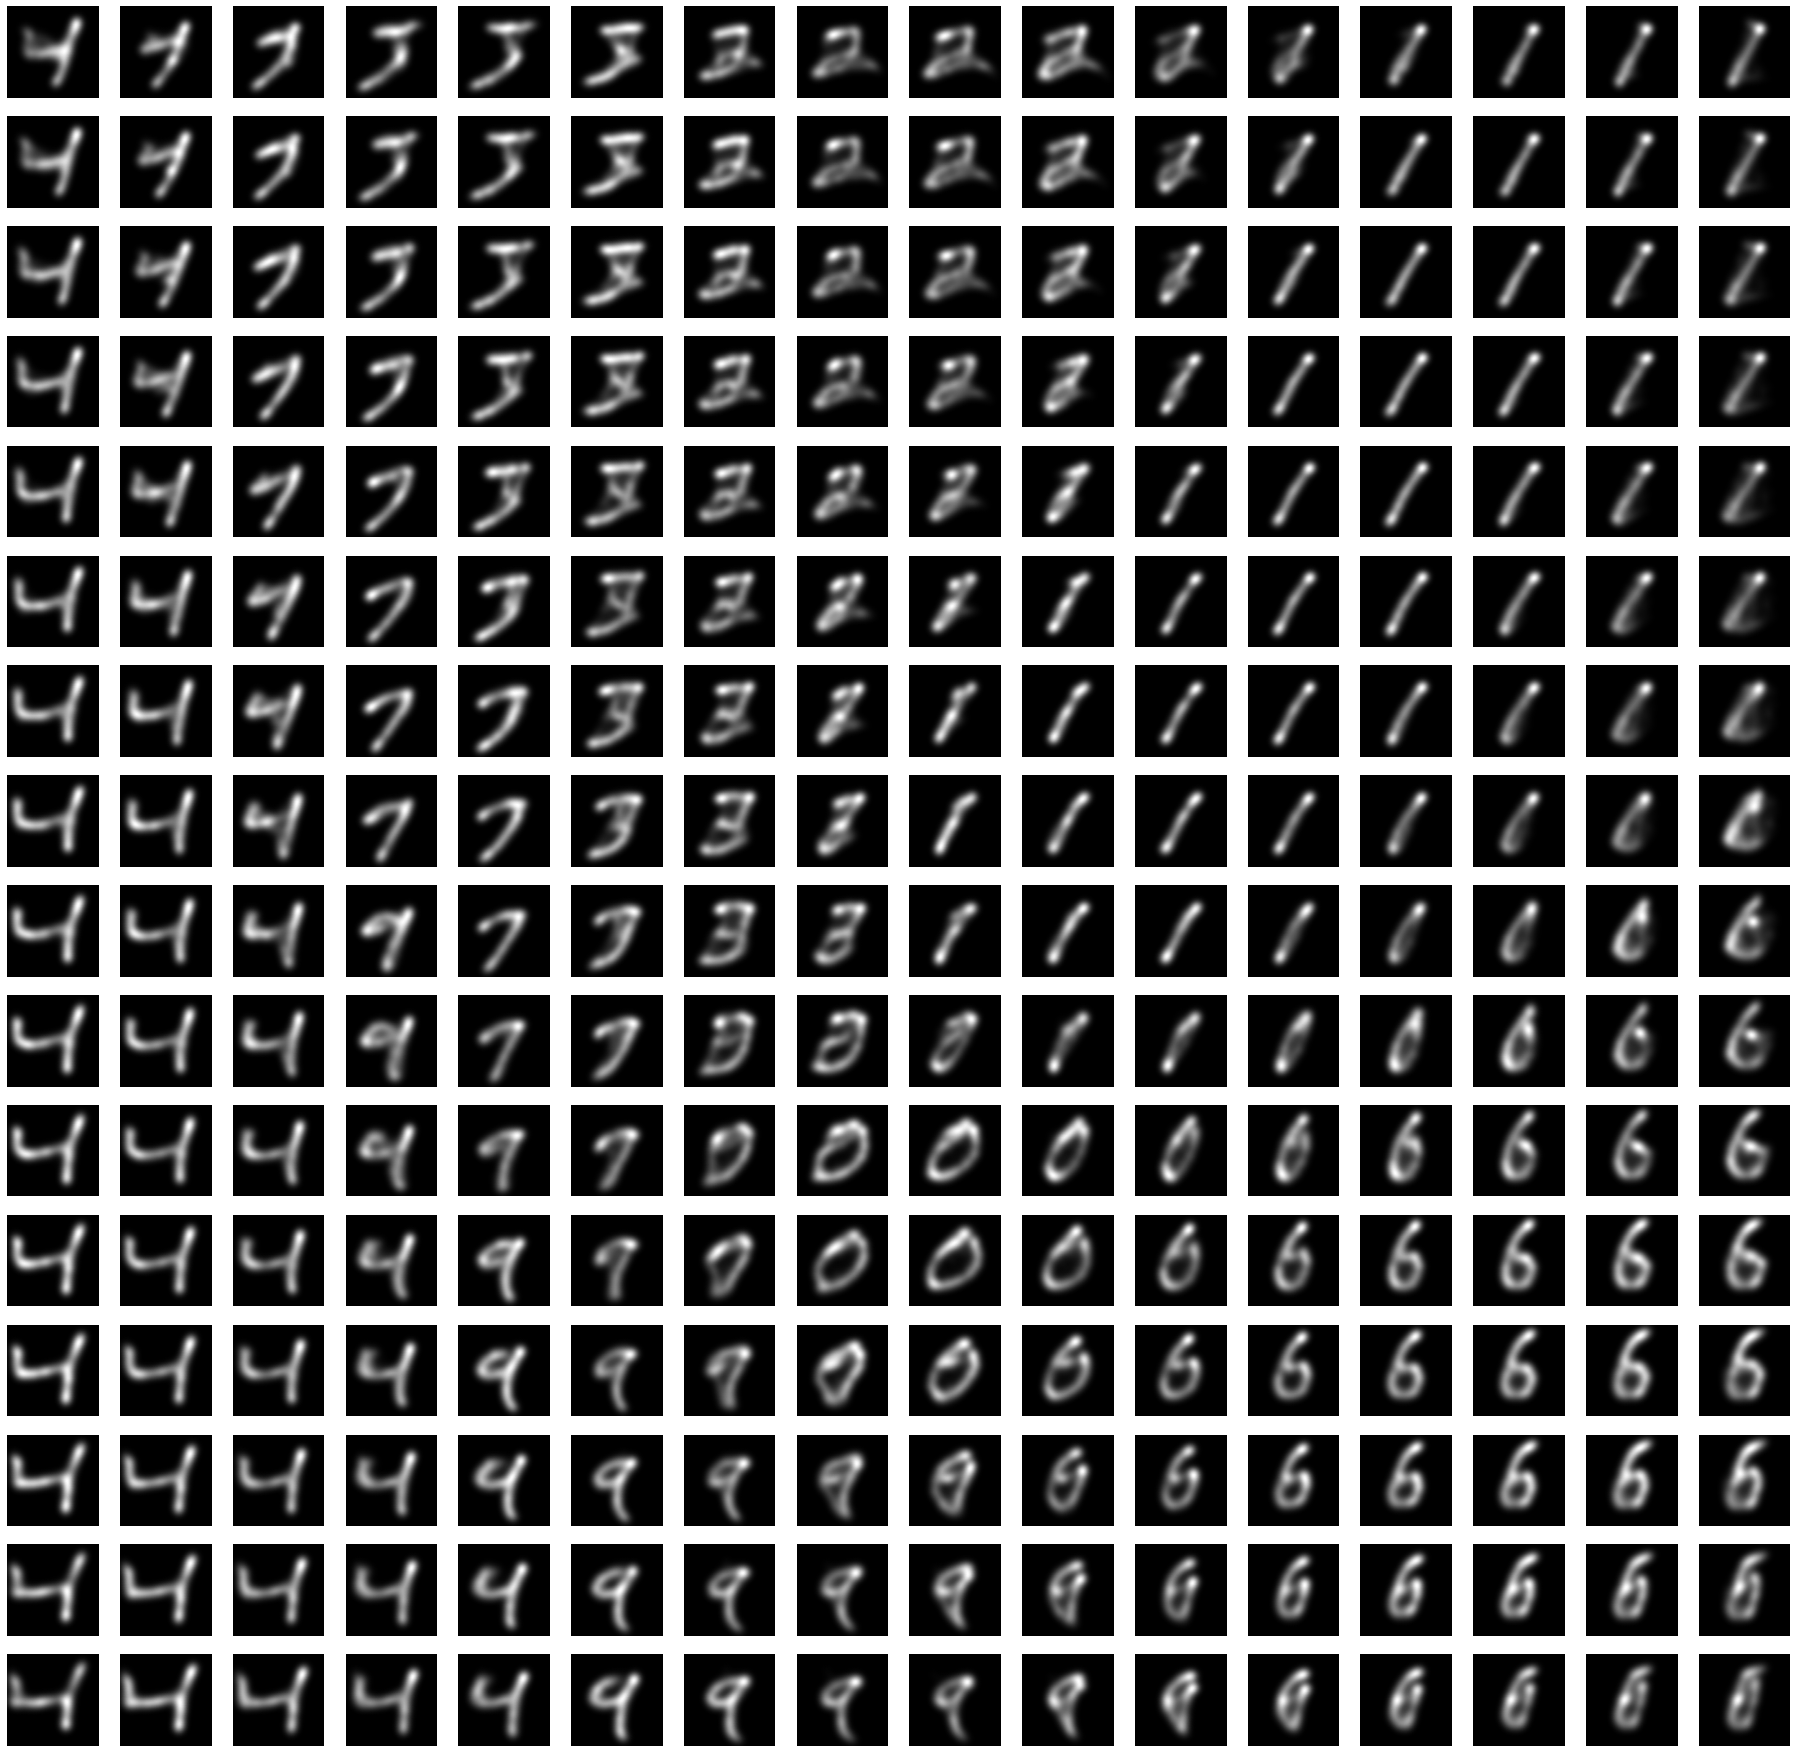

In [11]:
w = lvm.get_grid(axis_scale=np.linspace(-2, 2, 16)).reshape((-1, 2))
tmp_axis_scale, tmp_grid, tmp_conditional_distributions = lvm.calculate_conditional_distributions(model=model, w=torch.from_numpy(w), resolution=128)
visualization.show_densities_grid(axis_scale=tmp_axis_scale, probabilities=tmp_conditional_distributions, variable_name="x")